In [2]:
import lhapdf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from Results import *

# Global Constants
M1_test=np.sqrt(0.8)
Kp2A=0.57
Pp2A=0.12

ee=1
eU=2/3
eUbar=-2/3
eD=-1/3
eDbar=1/3
eS=-1/3
eSbar=1/3

AlphaU_test=1.0
BetaU_test=6.6
AlphaD_test=1.9
BetaD_test=10
AlphaS_test=0
BetaS_test=0

NU_test=0.18
NUbar_test=-0.01
ND_test=-0.52
NDbar_test=-0.06
NS_test=0
NSbar_test=0

M1_t2 = 1.303

AlphaU_t2=0.645
BetaU_t2=3.122
AlphaD_t2=1.777
BetaD_t2=7.788
AlphaS_t2=6.84*10**(-5)
BetaS_t2=5.987*10**(-10)

NU_t2=0.169
NUbar_t2=0.007
ND_t2=-0.434
NDbar_t2=-0.142
NS_t2=0.563
NSbar_t2=-0.122


# Here the data sets are listed and collected into and Array called "DataFilesArray"
Dat1='Data/HERMES_p_2009.csv'
Dat2='Data/HERMES_p_2020.csv'
Dat3='Data/COMPASS_d_2009.csv'
Dat4='Data/COMPASS_p_2015.csv'
DataFilesArray=[Dat1]
#PDFdataset = lhapdf.mkPDF("JAM19PDF_proton_nlo")
PDFdataset = lhapdf.mkPDF("cteq61")
#PDFdataset = lhapdf.mkPDF("CT10nnlo")
#FF_pion_dataset=["JAM19FF_pion_nlo"]
#FF_kaon_dataset=["JAM19FF_kaon_nlo"]
FF_PiP_dataset=["NNFF10_PIp_nlo"]
FF_PiM_dataset=["NNFF10_PIm_nlo"]
FF_Pi0_dataset=["NNFF10_PIsum_nlo"]
FF_KP_dataset=["NNFF10_KAp_nlo"]
FF_KM_dataset=["NNFF10_KAm_nlo"]

if DataFilesArray==[Dat1]:
    filename="Hermes 2009"
    result=result_H09
    result_cov=result_cov_H09
if DataFilesArray==[Dat2]:
    filename="Hermes 2020"
    result=result_H20
    result_cov=result_cov_H20
if DataFilesArray==[Dat3]:
    filename="Compass 2009"
    result=result_C09
    result_cov=result_cov_C09
if DataFilesArray==[Dat4]:
    filename="Compass 2015"
    result=result_C15
    result_cov=result_cov_C15

In [3]:
def hadarray(filename):
    tempdf=pd.read_csv(filename)
    temphad_data=tempdf["hadron"]
    temphad=temphad_data.dropna().unique()
    refined_had_array=[]
    for i in range(0,len(temphad)):
        if((temphad[i]=="pi+") or (temphad[i]=="pi-") or (temphad[i]=="pi0") or (temphad[i]=="k+") or (temphad[i]=="k-")):
            refined_had_array.append(temphad[i])
    return refined_had_array

#print(hadarray(Datafile))

def dataslice(filename,Had,Var):
    tempdf=pd.read_csv(filename)
    temp_slice=tempdf[(tempdf["hadron"]==Had)&(tempdf["1D_dependence"]==Var)]
    tempQ2=np.array(temp_slice["Q2"])
    tempX=np.array(temp_slice["x"])
    tempZ=np.array(temp_slice["z"])
    tempPHT=np.array(temp_slice["phT"])
    tempSiv=np.array(temp_slice["Siv"])
    temperrSiv=np.array(temp_slice["tot_err"])
    return tempQ2,tempX,tempZ,tempPHT,tempSiv,temperrSiv

def ks2Avg(m1,kperp2Avg):
    test_ks2Avg=((m1**2)*kperp2Avg)/((m1**2)+kperp2Avg)
    return test_ks2Avg

def A0(z,pht,m1,kperp2Avg,pperp2Avg,eCharg):
    tempA0part1=(((z**2)*kperp2Avg+pperp2Avg)*((ks2Avg(m1,kperp2Avg))**2))/((((z**2)*(ks2Avg(m1,kperp2Avg))+pperp2Avg)**2)*kperp2Avg)
    tempA0part21=(pht**2)*(z**2)*(ks2Avg(m1,kperp2Avg) - kperp2Avg)
    tempA0part22=((z**2)*(ks2Avg(m1,kperp2Avg))+pperp2Avg)*((z**2)*kperp2Avg+pperp2Avg)
    tempA0part2=np.exp(-tempA0part21/tempA0part22)
    tempA0part3=(np.sqrt(2*eCharg))*z*pht/m1
    tempA0=tempA0part1*tempA0part2*tempA0part3
    return tempA0

#def NNq(x,Nq,aq,bq):
#    tempNNq = Nq*(x**aq)*((1-x)**(bq))*((aq+bq)**(aq+bq))/((aq**aq)*(bq**bq))
#    return np.abs(tempNNq)

def NNq(x,Nq,aq,bq):
    aaq=abs(aq)
    bbq=abs(bq)
    tempNNq = Nq*(x**aaq)*((1-x)**(bbq))*((aaq+bbq)**(aaq+bbq))/((aaq**aaq)*(bbq**bbq))
    return tempNNq


def NNqbar(x,Nqbar):
    tempNNqbar = Nqbar
    return tempNNqbar

def xFxQ2(dataset,flavor,x,QQ):
    temp_parton_dist_x=np.array(dataset.xfxQ2(flavor, x, QQ))
    return temp_parton_dist_x

def zFzQ(dataset,flavor,zz,QQ):
    # Here "0" represents the central values from the girds
    temp_zD1=lhapdf.mkPDF(dataset[0], 0)
    zD1_vec=np.array(temp_zD1.xfxQ2(flavor,zz,QQ))
    return zD1_vec


def Asymmetry(QQ,x,z,pht,m1,Nu,au,bu,Nubar,Nd,ad,bd,Ndbar,Ns,aS,bs,Nsbar,lhaqID,lhaqbarID):
    kperp2Avg=Kp2A
    pperpAvg=Pp2A
    eCharg=ee
    if((lhaqID==2)and(lhaqbarID==-1)):
        ### This is pi+
        uCont1= NNq(x,Nu,au,bu)*(eU**2)*xFxQ2(PDFdataset,2,x,QQ)*zFzQ(FF_PiP_dataset,2,z,QQ)
        ubarCont1= NNqbar(x,Nubar)*(eUbar**2)*xFxQ2(PDFdataset,-2,x,QQ)*zFzQ(FF_PiP_dataset,-2,z,QQ)
        dCont1= NNq(x,Nd,ad,bd)*(eD**2)*xFxQ2(PDFdataset,1,x,QQ)*zFzQ(FF_PiP_dataset,1,z,QQ)
        dbarCont1= NNqbar(x,Ndbar)*(eDbar**2)*xFxQ2(PDFdataset,-1,x,QQ)*zFzQ(FF_PiP_dataset,-1,z,QQ)
        sCont1= NNq(x,Ns,aS,bs)*(eS**2)*xFxQ2(PDFdataset,3,x,QQ)*zFzQ(FF_PiP_dataset,3,z,QQ)
        sbarCont1= NNqbar(x,Nsbar)*(eSbar**2)*xFxQ2(PDFdataset,-3,x,QQ)*zFzQ(FF_PiP_dataset,-3,z,QQ)
        uCont2= (eU**2)*xFxQ2(PDFdataset,2,x,QQ)*zFzQ(FF_PiP_dataset,2,z,QQ)
        ubarCont2= (eUbar**2)*xFxQ2(PDFdataset,-2,x,QQ)*zFzQ(FF_PiP_dataset,-2,z,QQ)
        dCont2= (eD**2)*xFxQ2(PDFdataset,1,x,QQ)*zFzQ(FF_PiP_dataset,1,z,QQ)
        dbarCont2=(eDbar**2)*xFxQ2(PDFdataset,-1,x,QQ)*zFzQ(FF_PiP_dataset,-1,z,QQ)
        sCont2= (eS**2)*xFxQ2(PDFdataset,3,x,QQ)*zFzQ(FF_PiP_dataset,3,z,QQ)
        sbarCont2= (eSbar**2)*xFxQ2(PDFdataset,-3,x,QQ)*zFzQ(FF_PiP_dataset,-3,z,QQ)
        tempNumerator = uCont1 + ubarCont1 +dCont1 + dbarCont1 + sCont1 + sbarCont1
        tempDenominator = uCont2 + ubarCont2 +dCont2 + dbarCont2 + sCont2 + sbarCont2
        tempASiv = A0(z,pht,m1,kperp2Avg,pperpAvg,eCharg)*(tempNumerator/tempDenominator)
    elif((lhaqID==1)and(lhaqbarID==-2)):
        ### This is pi-
        uCont1= NNq(x,Nu,au,bu)*(eU**2)*xFxQ2(PDFdataset,2,x,QQ)*zFzQ(FF_PiM_dataset,2,z,QQ)
        ubarCont1= NNqbar(x,Nubar)*(eUbar**2)*xFxQ2(PDFdataset,-2,x,QQ)*zFzQ(FF_PiM_dataset,-2,z,QQ)
        dCont1= NNq(x,Nd,ad,bd)*(eD**2)*xFxQ2(PDFdataset,1,x,QQ)*zFzQ(FF_PiM_dataset,1,z,QQ)
        dbarCont1= NNqbar(x,Ndbar)*(eDbar**2)*xFxQ2(PDFdataset,-1,x,QQ)*zFzQ(FF_PiM_dataset,-1,z,QQ)
        sCont1= NNq(x,Ns,aS,bs)*(eS**2)*xFxQ2(PDFdataset,3,x,QQ)*zFzQ(FF_PiM_dataset,3,z,QQ)
        sbarCont1= NNqbar(x,Nsbar)*(eSbar**2)*xFxQ2(PDFdataset,-3,x,QQ)*zFzQ(FF_PiM_dataset,-3,z,QQ)
        uCont2= (eU**2)*xFxQ2(PDFdataset,2,x,QQ)*zFzQ(FF_PiM_dataset,2,z,QQ)
        ubarCont2= (eUbar**2)*xFxQ2(PDFdataset,-2,x,QQ)*zFzQ(FF_PiM_dataset,-2,z,QQ)
        dCont2= (eD**2)*xFxQ2(PDFdataset,1,x,QQ)*zFzQ(FF_PiM_dataset,1,z,QQ)
        dbarCont2= (eDbar**2)*xFxQ2(PDFdataset,-1,x,QQ)*zFzQ(FF_PiM_dataset,-1,z,QQ)
        sCont2= (eS**2)*xFxQ2(PDFdataset,3,x,QQ)*zFzQ(FF_PiM_dataset,3,z,QQ)
        sbarCont2= (eSbar**2)*xFxQ2(PDFdataset,-3,x,QQ)*zFzQ(FF_PiM_dataset,-3,z,QQ)
        tempNumerator = uCont1 + ubarCont1 +dCont1 + dbarCont1 + sCont1 + sbarCont1
        tempDenominator = uCont2 + ubarCont2 +dCont2 + dbarCont2 + sCont2 + sbarCont2
        tempASiv = A0(z,pht,m1,kperp2Avg,pperpAvg,eCharg)*(tempNumerator/tempDenominator)
    elif((lhaqID==1)and(lhaqbarID==-1)):
        ### This is pi0
        uCont1= NNq(x,Nu,au,bu)*(eU**2)*xFxQ2(PDFdataset,2,x,QQ)*zFzQ(FF_Pi0_dataset,2,z,QQ)
        ubarCont1= NNqbar(x,Nubar)*(eUbar**2)*xFxQ2(PDFdataset,-2,x,QQ)*zFzQ(FF_Pi0_dataset,-2,z,QQ)
        dCont1= NNq(x,Nd,ad,bd)*(eD**2)*xFxQ2(PDFdataset,1,x,QQ)*zFzQ(FF_Pi0_dataset,1,z,QQ)
        dbarCont1= NNqbar(x,Ndbar)*(eDbar**2)*xFxQ2(PDFdataset,-1,x,QQ)*zFzQ(FF_Pi0_dataset,-1,z,QQ)
        sCont1= NNq(x,Ns,aS,bs)*(eS**2)*xFxQ2(PDFdataset,3,x,QQ)*zFzQ(FF_Pi0_dataset,3,z,QQ)
        sbarCont1= NNqbar(x,Nsbar)*(eSbar**2)*xFxQ2(PDFdataset,-3,x,QQ)*zFzQ(FF_Pi0_dataset,-3,z,QQ)
        uCont2= (eU**2)*xFxQ2(PDFdataset,2,x,QQ)*zFzQ(FF_Pi0_dataset,2,z,QQ)
        ubarCont2= (eUbar**2)*xFxQ2(PDFdataset,-2,x,QQ)*zFzQ(FF_Pi0_dataset,-2,z,QQ)
        dCont2= (eD**2)*xFxQ2(PDFdataset,1,x,QQ)*zFzQ(FF_Pi0_dataset,1,z,QQ)
        dbarCont2= (eDbar**2)*xFxQ2(PDFdataset,-1,x,QQ)*zFzQ(FF_Pi0_dataset,-1,z,QQ)
        sCont2= (eS**2)*xFxQ2(PDFdataset,3,x,QQ)*zFzQ(FF_Pi0_dataset,3,z,QQ)
        sbarCont2= (eSbar**2)*xFxQ2(PDFdataset,-3,x,QQ)*zFzQ(FF_Pi0_dataset,-3,z,QQ)
        tempNumerator = uCont1 + ubarCont1 +dCont1 + dbarCont1 + sCont1 + sbarCont1
        tempDenominator = uCont2 + ubarCont2 +dCont2 + dbarCont2 + sCont2 + sbarCont2
        tempASiv = A0(z,pht,m1,kperp2Avg,pperpAvg,eCharg)*(tempNumerator/tempDenominator)
    elif((lhaqID==2)and(lhaqbarID==-3)):
        ### This is k+
        uCont1= NNq(x,Nu,au,bu)*(eU**2)*xFxQ2(PDFdataset,2,x,QQ)*zFzQ(FF_KP_dataset,2,z,QQ)
        ubarCont1= NNqbar(x,Nubar)*(eUbar**2)*xFxQ2(PDFdataset,-2,x,QQ)*zFzQ(FF_KP_dataset,-2,z,QQ)
        dCont1= NNq(x,Nd,ad,bd)*(eD**2)*xFxQ2(PDFdataset,1,x,QQ)*zFzQ(FF_KP_dataset,1,z,QQ)
        dbarCont1= NNqbar(x,Ndbar)*(eDbar**2)*xFxQ2(PDFdataset,-1,x,QQ)*zFzQ(FF_KP_dataset,-1,z,QQ)
        sCont1= NNq(x,Ns,aS,bs)*(eS**2)*xFxQ2(PDFdataset,3,x,QQ)*zFzQ(FF_KP_dataset,3,z,QQ)
        sbarCont1= NNqbar(x,Nsbar)*(eSbar**2)*xFxQ2(PDFdataset,-3,x,QQ)*zFzQ(FF_KP_dataset,-3,z,QQ)
        uCont2= (eU**2)*xFxQ2(PDFdataset,2,x,QQ)*zFzQ(FF_KP_dataset,2,z,QQ)
        ubarCont2= (eUbar**2)*xFxQ2(PDFdataset,-2,x,QQ)*zFzQ(FF_KP_dataset,-2,z,QQ)
        dCont2= (eD**2)*xFxQ2(PDFdataset,1,x,QQ)*zFzQ(FF_KP_dataset,1,z,QQ)
        dbarCont2= (eDbar**2)*xFxQ2(PDFdataset,-1,x,QQ)*zFzQ(FF_KP_dataset,-1,z,QQ)
        sCont2= (eS**2)*xFxQ2(PDFdataset,3,x,QQ)*zFzQ(FF_KP_dataset,3,z,QQ)
        sbarCont2= (eSbar**2)*xFxQ2(PDFdataset,-3,x,QQ)*zFzQ(FF_KP_dataset,-3,z,QQ)
        tempNumerator = uCont1 + ubarCont1 +dCont1 + dbarCont1 + sCont1 + sbarCont1
        tempDenominator = uCont2 + ubarCont2 +dCont2 + dbarCont2 + sCont2 + sbarCont2
        tempASiv = A0(z,pht,m1,kperp2Avg,pperpAvg,eCharg)*(tempNumerator/tempDenominator)
    elif((lhaqID==3)and(lhaqbarID==-2)):
        ### This is k+
        uCont1= NNq(x,Nu,au,bu)*(eU**2)*xFxQ2(PDFdataset,2,x,QQ)*zFzQ(FF_KM_dataset,2,z,QQ)
        ubarCont1= NNqbar(x,Nubar)*(eUbar**2)*xFxQ2(PDFdataset,-2,x,QQ)*zFzQ(FF_KM_dataset,-2,z,QQ)
        dCont1= NNq(x,Nd,ad,bd)*(eD**2)*xFxQ2(PDFdataset,1,x,QQ)*zFzQ(FF_KM_dataset,1,z,QQ)
        dbarCont1= NNqbar(x,Ndbar)*(eDbar**2)*xFxQ2(PDFdataset,-1,x,QQ)*zFzQ(FF_KM_dataset,-1,z,QQ)
        sCont1= NNq(x,Ns,aS,bs)*(eS**2)*xFxQ2(PDFdataset,3,x,QQ)*zFzQ(FF_KM_dataset,3,z,QQ)
        sbarCont1= NNqbar(x,Nsbar)*(eSbar**2)*xFxQ2(PDFdataset,-3,x,QQ)*zFzQ(FF_KM_dataset,-3,z,QQ)
        uCont2= (eU**2)*xFxQ2(PDFdataset,2,x,QQ)*zFzQ(FF_KM_dataset,2,z,QQ)
        ubarCont2= (eUbar**2)*xFxQ2(PDFdataset,-2,x,QQ)*zFzQ(FF_KM_dataset,-2,z,QQ)
        dCont2= (eD**2)*xFxQ2(PDFdataset,1,x,QQ)*zFzQ(FF_KM_dataset,1,z,QQ)
        dbarCont2= (eDbar**2)*xFxQ2(PDFdataset,-1,x,QQ)*zFzQ(FF_KM_dataset,-1,z,QQ)
        sCont2= (eS**2)*xFxQ2(PDFdataset,3,x,QQ)*zFzQ(FF_KM_dataset,3,z,QQ)
        sbarCont2= (eSbar**2)*xFxQ2(PDFdataset,-3,x,QQ)*zFzQ(FF_KM_dataset,-3,z,QQ)
        tempNumerator = uCont1 + ubarCont1 +dCont1 + dbarCont1 + sCont1 + sbarCont1
        tempDenominator = uCont2 + ubarCont2 +dCont2 + dbarCont2 + sCont2 + sbarCont2
        tempASiv = A0(z,pht,m1,kperp2Avg,pperpAvg,eCharg)*(tempNumerator/tempDenominator)
    return tempASiv

In [4]:
## ** two stars represents a dictionary
def ASivFitHadron(hadron,KV,**parms):
    m1= parms["m1"]
    Nu = parms["Nu"]
    alphau= parms["alphau"]
    betau = parms["betau"]
    Nubar = parms["Nubar"]
    Nd = parms["Nd"]
    alphad= parms["alphad"]
    betad = parms["betad"]
    Ndbar = parms["Ndbar"]
    Ns = parms["Ns"]
    alphas= parms["alphas"]
    betas = parms["betas"]
    Nsbar = parms["Nsbar"]
    if(hadron=="pi+"):
        Qflag=2
        AniQflag=-1
    elif(hadron=="pi-"):
        Qflag=1
        AniQflag=-2
    elif(hadron=="pi0"):
        Qflag=1
        AniQflag=-1
    elif(hadron=="k+"):
        Qflag=2
        AniQflag=-3
    elif(hadron=="k-"):
        Qflag=3
        AniQflag=-2
    ################
    QQ,x,z,pht=KV
    array_size=len(x)
    tempASivHad_val=[]
    for i in range(0,array_size):
        tempASivHad=Asymmetry(QQ[i],x[i],z[i],pht[i],m1,Nu,alphau,betau,Nubar,Nd,alphad,betad,Ndbar,Ns,alphas,betas,Nsbar,Qflag,AniQflag)       
        tempASivHad_val.append(tempASivHad)
    return tempASivHad_val


In [5]:
def Kin_hadron(datfile,hadron):
    tempXfile=dataslice(datfile,hadron,"x")
    tempZfile=dataslice(datfile,hadron,"z")
    tempPhTfile=dataslice(datfile,hadron,"phT")
    ##### Q2 ################
    tempQ2_x=np.array(tempXfile[0])
    tempQ2_z=np.array(tempZfile[0])
    tempQ2_phT=np.array(tempPhTfile[0])
    tempQ2=np.concatenate((tempQ2_x,tempQ2_z,tempQ2_phT))
    ##### X ################
    tempX_x=np.array(tempXfile[1])
    tempX_z=np.array(tempZfile[1])
    tempX_phT=np.array(tempPhTfile[1])
    tempX=np.concatenate((tempX_x,tempX_z,tempX_phT))
    ##### Z ################
    tempZ_x=np.array(tempXfile[2])
    tempZ_z=np.array(tempZfile[2])
    tempZ_phT=np.array(tempPhTfile[2])
    tempZ=np.concatenate((tempZ_x,tempZ_z,tempZ_phT))
    ##### phT ################
    tempphT_x=np.array(tempXfile[3])
    tempphT_z=np.array(tempZfile[3])
    tempphT_phT=np.array(tempPhTfile[3])
    tempphT=np.concatenate((tempphT_x,tempphT_z,tempphT_phT))
    return tempQ2,tempX,tempZ,tempphT


def Kin_Had(datfile):
    had_len=len(hadarray(datfile))
    temHads=hadarray(datfile)
    temp_kin=[]
    for i in range(0,had_len):
        temp_kin.append(Kin_hadron(datfile,temHads[i]))        
    return temp_kin

#print(len(Kin_Had(Datafile)))
#print(Kin_Had(Datafile)[3])


#### Sivers values

def ASiv_data(datfile,hadron):
    tempXfile=dataslice(datfile,hadron,"x")
    tempZfile=dataslice(datfile,hadron,"z")
    tempPhTfile=dataslice(datfile,hadron,"phT")    
    ##### Asy ################
    tempAsy_x=np.array(tempXfile[4])
    tempAsy_z=np.array(tempZfile[4])
    tempAsy_phT=np.array(tempPhTfile[4])
    tempAsy=np.concatenate((tempAsy_x,tempAsy_z,tempAsy_phT))
    ##### err ################
    tempAsyErr_x=np.array(tempXfile[5])
    tempAsyErr_z=np.array(tempZfile[5])
    tempAsyErr_phT=np.array(tempPhTfile[5])
    tempAsyErr=np.concatenate((tempAsyErr_x,tempAsyErr_z,tempAsyErr_phT))
    return tempAsy,tempAsyErr

def ASiv_Val(datfile):
    had_len=len(hadarray(datfile))
    temHads=hadarray(datfile)
    temp_SivData=[]
    for i in range(0,had_len):
        temp_SivData.append(ASiv_data(datfile,temHads[i])[0])        
    return temp_SivData

def ASiv_Err(datfile):
    had_len=len(hadarray(datfile))
    temHads=hadarray(datfile)
    temp_SivData=[]
    for i in range(0,had_len):
        temp_SivData.append(ASiv_data(datfile,temHads[i])[1])        
    return temp_SivData


In [6]:
def totalfitDataSet(datfile,m1,Nu,alphau,betau,Nubar,Nd,alphad,betad,Ndbar,Ns,alphas,betas,Nsbar):
    had_len=len(hadarray(datfile))
    temHads=hadarray(datfile)
    fittot=[]
    for i in range(0,had_len):
        if temHads[i]=="pi+":
            tempfit=ASivFitHadron("pi+",Kin_hadron(datfile,"pi+"),m1=m1,Nu=Nu,alphau=alphau,betau=betau,Nubar=Nubar,Nd=Nd,alphad=alphad,betad=betad,Ndbar=Ndbar,Ns=Ns,alphas=alphas,betas=betas,Nsbar=Nsbar)
            fittot.append(tempfit)
        elif temHads[i]=="pi-":
            tempfit=ASivFitHadron("pi-",Kin_hadron(datfile,"pi-"),m1=m1,Nu=Nu,alphau=alphau,betau=betau,Nubar=Nubar,Nd=Nd,alphad=alphad,betad=betad,Ndbar=Ndbar,Ns=Ns,alphas=alphas,betas=betas,Nsbar=Nsbar)
            fittot.append(tempfit)
        elif temHads[i]=="pi0":
            tempfit=ASivFitHadron("pi0",Kin_hadron(datfile,"pi0"),m1=m1,Nu=Nu,alphau=alphau,betau=betau,Nubar=Nubar,Nd=Nd,alphad=alphad,betad=betad,Ndbar=Ndbar,Ns=Ns,alphas=alphas,betas=betas,Nsbar=Nsbar)
            fittot.append(tempfit)
        elif temHads[i]=="k+":
            tempfit=ASivFitHadron("k+",Kin_hadron(datfile,"k+"),m1=m1,Nu=Nu,alphau=alphau,betau=betau,Nubar=Nubar,Nd=Nd,alphad=alphad,betad=betad,Ndbar=Ndbar,Ns=Ns,alphas=alphas,betas=betas,Nsbar=Nsbar)
            fittot.append(tempfit)
        elif temHads[i]=="k-":
            tempfit=ASivFitHadron("k-",Kin_hadron(datfile,"k-"),m1=m1,Nu=Nu,alphau=alphau,betau=betau,Nubar=Nubar,Nd=Nd,alphad=alphad,betad=betad,Ndbar=Ndbar,Ns=Ns,alphas=alphas,betas=betas,Nsbar=Nsbar)
            fittot.append(tempfit)
    return np.concatenate((fittot), axis=None)


### This function will combine all the data sets into a single array

def totalfitfunc(datfilesarray,m1,Nu,alphau,betau,Nubar,Nd,alphad,betad,Ndbar,Ns,alphas,betas,Nsbar):
    datfilesnum=len(datfilesarray)
    temptotal=[]
    for i in range(0,datfilesnum):
        temptotal.append(totalfitDataSet(datfilesarray[i],m1,Nu,alphau,betau,Nubar,Nd,alphad,betad,Ndbar,Ns,alphas,betas,Nsbar))
    return np.concatenate((temptotal), axis=None)


### This function collects all data and combine together into one array
    
def SiversVals(datafilesarray):
    datfilesnum=len(datafilesarray)
    tempSiv=[]
    for i in range(0,datfilesnum):
        tempSiv.append(ASiv_Val(datafilesarray[i]))
    tempflatSiv=np.concatenate((tempSiv), axis=None)
    return np.concatenate((tempflatSiv), axis=None)

def SiversErrVals(datafilesarray):
    datfilesnum=len(datafilesarray)
    tempSivErr=[]
    for i in range(0,datfilesnum):
        tempSivErr.append(ASiv_Err(datafilesarray[i]))
    tempflatSivErr=np.concatenate((tempSivErr), axis=None)
    return np.concatenate((tempflatSivErr), axis=None)


In [16]:
### This is where I'm trying to do the global fit
def totalfitfunc(datfilesarray,m1,Nu,alphau,betau,Nubar,Nd,alphad,betad,Ndbar,Ns,alphas,betas,Nsbar):
    Dat1='Data/HERMES_p_2009.csv'
    Dat2='Data/HERMES_p_2020.csv'
    Dat3='Data/COMPASS_d_2009.csv'
    Dat4='Data/COMPASS_p_2015.csv'
    datfilesarray=[Dat2]
    datfilesnum=len(datfilesarray)
    temptotal=[]
    for i in range(0,datfilesnum):
        temptotal.append(totalfitDataSet(datfilesarray[i],m1,Nu,alphau,betau,Nubar,Nd,alphad,betad,Ndbar,Ns,alphas,betas,Nsbar))
    return np.concatenate((temptotal), axis=None)

p0=M1_t2,NU_t2,AlphaU_t2,BetaU_t2,NUbar_t2,ND_t2,AlphaD_t2,BetaD_t2,NDbar_t2,NS_t2,AlphaS_t2,BetaS_t2,NSbar_t2
#p0=1,1,1,1,1,1,1,1,1,1,1,1,1
result, result_cov=opt.curve_fit(totalfitfunc,pd.get_dummies(DataFilesArray),SiversVals(DataFilesArray),p0,sigma=SiversErrVals(DataFilesArray),method='lm')
#result, result_cov=opt.curve_fit(totalfitfunc,DataFilesArray,SiversVals(DataFilesArray),p0,sigma=SiversErrVals(DataFilesArray),method='lm')

In [19]:
result

array([1197.0455036 ,  157.85346861,    2.2465053 ,   12.33432802,
        -24.0948017 , -501.17286986,    1.6656108 ,   -2.62784958,
       -223.22865753,  885.83438323,    2.632221  ,  -17.03173635,
       -244.28188978])

In [18]:
result_cov

array([[ 3.54061883e+15,  4.66898268e+14, -4.71817537e+06,
        -1.81317811e+07, -7.12702429e+13, -1.48236726e+15,
        -4.59243231e+06,  1.41710549e+07, -6.60269395e+14,
         2.62013648e+15, -1.21366907e+06, -1.53158839e+06,
        -7.22544057e+14],
       [ 4.66898268e+14,  6.15694610e+13, -6.22181198e+05,
        -2.39102443e+06, -9.39834378e+12, -1.95478457e+14,
        -6.05597920e+05,  1.86871815e+06, -8.70691401e+13,
         3.45515075e+14, -1.60045829e+05, -2.01961836e+05,
        -9.52812447e+13],
       [-4.71817834e+06, -6.22181589e+05,  1.54078006e-01,
         9.44093386e-01,  9.49745637e+04,  1.97540849e+06,
         2.55454997e-03, -2.23768998e-01,  8.79878884e+05,
        -3.49155273e+06,  8.16380767e-02, -3.89898697e-01,
         9.62889804e+05],
       [-1.81317998e+07, -2.39102690e+06,  9.44093396e-01,
         6.56537639e+00,  3.64986696e+05,  7.59155630e+06,
        -1.58771409e-01, -1.16699339e+00,  3.38136838e+06,
        -1.34179298e+07,  6.71991589e

In [6]:
resultH09 =([ 1.30340206e+00,  1.69545390e-01,  6.45520993e-01,  3.12185077e+00,
        7.60454727e-03, -4.34490966e-01,  1.77725228e+00,  7.78838430e+00,
       -1.41958803e-01,  5.62612315e-01,  6.84420220e-05,  5.98748065e-10,
       -1.22062004e-01])
result_cov_H09 = ([[ 5.91342007e-02,  4.35054525e-03, -4.91697414e-02,
        -1.20757843e-01, -2.69161138e-04, -6.18279186e-03,
         2.40874651e-03,  9.60239570e-02, -3.26756848e-02,
        -1.14863614e-03, -1.20308863e-02,  4.70341396e-05,
        -8.58350306e-02],
       [ 4.35054525e-03,  1.14060806e-03, -1.05122198e-02,
        -6.29845223e-02, -9.24105460e-04, -2.54318268e-03,
         1.65198432e-02,  2.85675930e-02, -1.00232632e-02,
         6.92581622e-03, -2.55373066e-04,  1.11329186e-05,
        -3.01196398e-02],
       [-4.91697414e-02, -1.05122198e-02,  6.60066263e-01,
         3.32267351e+00,  5.55534054e-02, -2.08161082e-02,
        -2.11147309e-01,  5.62329229e-01,  3.36702123e-01,
        -3.33415815e-02,  2.70486302e-01, -3.62226547e-04,
         1.07495351e+00],
       [-1.20757843e-01, -6.29845223e-02,  3.32267351e+00,
         2.04245018e+01,  2.79802361e-01,  7.20536740e-02,
         1.40108874e-01,  1.41795697e+01,  1.33381064e+00,
        -2.01684488e-01,  1.36804386e+00, -1.20943842e-03,
         4.16808376e+00],
       [-2.69161138e-04, -9.24105460e-04,  5.55534054e-02,
         2.79802361e-01,  3.00048318e-02, -1.08571513e-02,
        -2.51345795e-01, -9.92413787e-01,  4.96010345e-02,
        -7.18947077e-02,  1.26718099e-01,  7.25495474e-05,
         1.17044006e-01],
       [-6.18279186e-03, -2.54318268e-03, -2.08161082e-02,
         7.20536740e-02, -1.08571513e-02,  3.34570010e-02,
         1.05839558e-01,  9.71248674e-01, -2.42019003e-02,
         3.35224910e-02, -3.76196545e-02, -1.36068103e-05,
        -7.14174274e-02],
       [ 2.40874651e-03,  1.65198432e-02, -2.11147309e-01,
         1.40108874e-01, -2.51345795e-01,  1.05839558e-01,
         5.08913224e+00,  2.80510990e+01, -6.11846636e-01,
         4.36701396e-01, -1.14046001e+00, -4.60500751e-05,
        -1.66807622e+00],
       [ 9.60239570e-02,  2.85675930e-02,  5.62329229e-01,
         1.41795697e+01, -9.92413787e-01,  9.71248674e-01,
         2.80510990e+01,  1.76812553e+02, -2.52456150e+00,
         1.36383998e+00, -4.75564885e+00,  5.07215720e-04,
        -6.90265983e+00],
       [-3.26756848e-02, -1.00232632e-02,  3.36702123e-01,
         1.33381064e+00,  4.96010345e-02, -2.42019003e-02,
        -6.11846636e-01, -2.52456150e+00,  3.02744649e-01,
        -1.22010518e-01,  1.79128549e-01, -2.59262668e-04,
         8.20936536e-01],
       [-1.14863614e-03,  6.92581622e-03, -3.33415815e-02,
        -2.01684488e-01, -7.18947077e-02,  3.35224910e-02,
         4.36701396e-01,  1.36383998e+00, -1.22010518e-01,
         4.50473981e-01, -1.06765493e-01, -1.65420240e-04,
        -2.82696818e-01],
       [-1.20308863e-02, -2.55373066e-04,  2.70486302e-01,
         1.36804386e+00,  1.26718099e-01, -3.76196545e-02,
        -1.14046001e+00, -4.75564885e+00,  1.79128549e-01,
        -1.06765493e-01,  6.84337905e-01,  3.90131566e-04,
         3.73887167e-01],
       [ 4.70341396e-05,  1.11329186e-05, -3.62226547e-04,
        -1.20943842e-03,  7.25495474e-05, -1.36068103e-05,
        -4.60500751e-05,  5.07215720e-04, -2.59262668e-04,
        -1.65420240e-04,  3.90131566e-04,  2.13514594e-05,
        -1.14804587e-03],
       [-8.58350306e-02, -3.01196398e-02,  1.07495351e+00,
         4.16808376e+00,  1.17044006e-01, -7.14174274e-02,
        -1.66807622e+00, -6.90265983e+00,  8.20936536e-01,
        -2.82696818e-01,  3.73887167e-01, -1.14804587e-03,
         3.14267655e+00]])

In [7]:
theoryH09=totalfitfunc(DataFilesArray,*result)

def totchi2(y,yhat,err):
    tempval=np.sum(((y-yhat)/err)**2)
    return tempval

print(totchi2(SiversVals(DataFilesArray),theoryH09,SiversErrVals(DataFilesArray))/len(SiversVals(DataFilesArray)))

1.8402503575770657


In [ ]:
def param_samples(pars, cov):
    par_sample = []
    pars_sigma=np.diag(cov)
    org_theory=totalfitfunc(DataFilesArray,*pars)
    org_chi2=totchi2(SiversVals(DataFilesArray),org_theory,SiversErrVals(DataFilesArray))
    #print(org_chi2)
    for i in range(100):
        #temp_pars = np.random.normal(pars, 0.1*np.diag(cov))
        temp_pars = np.random.normal(pars, 0.001*np.diag(cov))
        par_sample.append(temp_pars)
        temp_theory=totalfitfunc(DataFilesArray,*temp_pars)
        temp_chi2=totchi2(SiversVals(DataFilesArray),temp_theory,SiversErrVals(DataFilesArray))
        #print(temp_chi2)
        if(np.abs(org_chi2-temp_chi2)<134):
            par_sample.append(temp_pars)
        #temp_theory=ASivFitHadron(had,(tempQ,tempX,tempZ,tempphT),m1=result[0],Nu=result[1],alphau=result[2],betau=result[3],Nubar=result[4],Nd=result[5],alphad=result[6],betad=result[7],Ndbar=result[8],Ns=result[9],alphas=result[10],betas=result[11],Nsbar=result[12])
        #d = func(X, *temp_pars).real
        #res.append(list(d))
    return np.array(par_sample)

test_parms=param_samples(result, result_cov)


In [ ]:
test_parm_1=test_parms

def KinSlicer(array, bn):
    a_size=len(array)
    temp_arr=[]
    for i in range(0,a_size):
        temp_arr.append(array[i][bn])
    mx=np.max(temp_arr)
    mn=np.min(temp_arr)
    return(mx,mn)

def PlotSivHadBand(datfile,hadron,dependence,resultarray,param_array):
    data_points=len(dataslice(datfile,hadron,dependence)[0])
    temp_kinematics=np.array(dataslice(datfile,hadron,dependence))
    if(dependence=="x"):
        dep_index=1
    elif(dependence=="z"):
        dep_index=2
    elif(dependence=="phT"):
        dep_index=3
    tempQ=temp_kinematics[0]
    tempX=temp_kinematics[1]
    tempZ=temp_kinematics[2]
    tempphT=temp_kinematics[3]
    temp_exp=temp_kinematics[4]
    temp_sigma=temp_kinematics[5]
    temp_size=len(param_array)
    temp_size_kin=len(tempQ)
    temp_ASiv_vals=[]
    temp_ASiv_max=[]
    temp_ASiv_min=[]
    for i in range(0,temp_size):
        RS=param_array[i]
        temp_theory=ASivFitHadron(hadron,(tempQ,tempX,tempZ,tempphT),m1=RS[0],Nu=RS[1],alphau=RS[2],betau=RS[3],Nubar=RS[4],Nd=RS[5],alphad=RS[6],betad=RS[7],Ndbar=RS[8],Ns=RS[9],alphas=RS[10],betas=RS[11],Nsbar=RS[12])  
        #print(temp_theory)
        temp_ASiv_vals.append(temp_theory)
    for j in range(0,temp_size_kin):
        temp_ASiv_max.append(KinSlicer(temp_ASiv_vals, j)[0])
        temp_ASiv_min.append(KinSlicer(temp_ASiv_vals, j)[1])        
    temp_theory_central=ASivFitHadron(hadron   ,(tempQ,tempX,tempZ,tempphT),m1=resultarray[0],Nu=resultarray[1],alphau=resultarray[2],betau=resultarray[3],Nubar=resultarray[4],Nd=resultarray[5],alphad=resultarray[6],betad=resultarray[7],Ndbar=resultarray[8],Ns=resultarray[9],alphas=resultarray[10],betas=resultarray[11],Nsbar=resultarray[12])
    plt.plot(temp_kinematics[dep_index],temp_theory_central,'red',label='Fit')
    #plt.plot(temp_kinematics[dep_index],temp_ASiv_max,'green')
    #plt.plot(temp_kinematics[dep_index],temp_ASiv_min,'orange')
    plt.fill_between(temp_kinematics[dep_index],temp_ASiv_min,temp_ASiv_max,alpha=0.2,color='red')
    plt.errorbar(temp_kinematics[dep_index],temp_kinematics[4],temp_kinematics[5],fmt='o',color='blue',label='Data')
    #plt.xlabel(dependence)
    #plt.ylabel(hadron)
    #print(np.array(temp_ASiv_max)-np.array(temp_ASiv_min))
    #return temp_ASiv_vals
    #return temp_ASiv_max,temp_ASiv_min

In [ ]:
def hfunc(kp,m1):
    temphfunc=np.sqrt(2*ee)*(kp/m1)*(np.exp((-kp**2)/(m1**2)))
    return temphfunc

def SiversFuncQ(dataset,flavor,x,QQ,kp,fitresult):
    tempM1=fitresult[0]
    if(flavor==2):
        Nq=fitresult[1]
        aq=fitresult[2]
        bq=fitresult[3]
        tempsiv=2*NNq(x,Nq,aq,bq)*hfunc(kp,tempM1)*(np.exp((-kp**2)/(Kp2A**2)))*(1/((np.pi)*(Kp2A**2)))*(xFxQ2(dataset,flavor,x,QQ))
    if(flavor==1):
        Nq=fitresult[5]
        aq=fitresult[6]
        bq=fitresult[7]
        tempsiv=2*NNq(x,Nq,aq,bq)*hfunc(kp,tempM1)*(np.exp((-kp**2)/(Kp2A**2)))*(1/((np.pi)*(Kp2A**2)))*(xFxQ2(dataset,flavor,x,QQ))
    if(flavor==3):
        Nq=fitresult[9]
        aq=fitresult[10]
        bq=fitresult[11]
        tempsiv=2*NNq(x,Nq,aq,bq)*hfunc(kp,tempM1)*(np.exp((-kp**2)/(Kp2A**2)))*(1/((np.pi)*(Kp2A**2)))*(xFxQ2(dataset,flavor,x,QQ))
    return x*tempsiv

        
def SiversFuncAntiQ(dataset,flavor,x,QQ,kp,fitresult):
    tempM1=fitresult[0]
    if(flavor==-2):
        tempM1=fitresult[0]
        Nq=fitresult[4]
        tempsiv=2*NNqbar(x,Nq)*hfunc(kp,tempM1)*(np.exp((-kp**2)/(Kp2A**2)))*(1/((np.pi)*(Kp2A**2)))*(xFxQ2(dataset,flavor,x,QQ))
    if(flavor==-1):
        tempM1=fitresult[0]
        Nq=fitresult[8]
        tempsiv=2*NNqbar(x,Nq)*hfunc(kp,tempM1)*(np.exp((-kp**2)/(Kp2A**2)))*(1/((np.pi)*(Kp2A**2)))*(xFxQ2(dataset,flavor,x,QQ))
    if(flavor==-3):
        tempM1=fitresult[0]
        Nq=fitresult[12]
        tempsiv=2*NNqbar(x,Nq)*hfunc(kp,tempM1)*(np.exp((-kp**2)/(Kp2A**2)))*(1/((np.pi)*(Kp2A**2)))*(xFxQ2(dataset,flavor,x,QQ))
    return x*tempsiv


def plotSiversQ(flavor):
    tempkT=np.linspace(0, 1.5)
    tempSiv=[SiversFuncQ(PDFdataset,flavor,0.1,2.4,tempkT[i],result) for i in range(0,len(tempkT))]
    plt.plot(tempkT,tempSiv)
    #return tempSiv

def plotSiversAntiQ(flavor):
    tempkT=np.linspace(0, 1.5)
    tempSiv=[SiversFuncAntiQ(PDFdataset,flavor,0.1,2.4,tempkT[i],result) for i in range(0,len(tempkT))]
    plt.plot(tempkT,tempSiv)

    
def plotSiversQBand(flavor,array,col,lbl):
    tempkT=np.linspace(0, 1.5)
    lenarray=len(array)
    tempASivVal=[]
    for j in range(0,lenarray):
        ttt=[SiversFuncQ(PDFdataset,flavor,0.1,2.4,tempkT[i],array[j]) for i in range(0,len(tempkT))]
        plt.plot(tempkT,ttt,color=col,alpha=0.1) 
    tempSiv=[SiversFuncQ(PDFdataset,flavor,0.1,2.4,tempkT[i],result) for i in range(0,len(tempkT))]
    plt.plot(tempkT,tempSiv,col,label=lbl)
    #return tempSiv
    
    
def plotSiversAntiQBand(flavor,array,col,lbl):
    tempkT=np.linspace(0, 1.5)
    lenarray=len(array)
    tempASivVal=[]
    for j in range(0,lenarray):
        ttt=[SiversFuncAntiQ(PDFdataset,flavor,0.1,2.4,tempkT[i],array[j]) for i in range(0,len(tempkT))]
        plt.plot(tempkT,ttt,color=col,alpha=0.1) 
    tempSiv=[SiversFuncAntiQ(PDFdataset,flavor,0.1,2.4,tempkT[i],result) for i in range(0,len(tempkT))]
    plt.plot(tempkT,tempSiv,col,label=lbl)
    
#Please change 'test_parm_1' with the correct array name
ff1=plt.figure(5,figsize=(12,10))
plotSiversQBand(2,test_parm_1,'blue','$u$')
plotSiversQBand(1,test_parm_1,'red','$d$')
plotSiversQBand(3,test_parm_1,'green','$s$')
plt.legend(loc=1,fontsize=20,handlelength=3)
plt.title("HERMES 2009",fontsize=25)
plt.xlabel('$k_{\perp}$',fontsize=25)
plt.ylabel('$x \Delta^N f(x,k_{\perp})$',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(loc=1,fontsize=25,handlelength=3)
#ff1.savefig('HERMES2009QuarkSivers.pdf')


ff2=plt.figure(6,figsize=(12,10))
plotSiversAntiQBand(-2,test_parm_1,'blue','$u_{sea}$')
plotSiversAntiQBand(-1,test_parm_1,'red','$d_{sea}$')
plotSiversAntiQBand(-3,test_parm_1,'green','$s_{sea}$')
plt.title("HERMES 2009",fontsize=25)
plt.xlabel('$k_{\perp}$',fontsize=25)
plt.ylabel('$x \Delta^N f(x,k_{\perp})$',fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(loc=4,fontsize=20,handlelength=3)
#ff2.savefig('HERMES2009AntiQuarkSivers.pdf')

Text(0.5, 1.0, 'HERMES 2009')

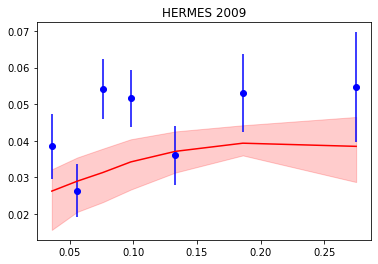

In [46]:
dep="x"
had="pi+"

#test_asy_arrays=PlotSivHadBand(DataFilesArray[0],had,dep,test_parms)
PlotSivHadBand(DataFilesArray[0],had,dep,result,test_parms)
plt.title("HERMES 2009")

In [12]:
print(test_parm_1)

[[ 5.39043180e+01 -5.11633591e+00  1.55946452e+00 ...  7.00105811e+00
   1.29893085e+02  3.56719707e+02]
 [-1.60917605e+02  1.53284134e+00  3.10933701e+00 ...  2.68804258e+00
   5.15413783e+01  3.77129327e+02]
 [-3.70005630e+02  2.60349628e+00  4.19188884e+00 ...  1.72059088e+01
  -7.93016195e+01 -4.11441129e+02]
 ...
 [ 6.31042436e+02 -6.56022253e-02  1.57033558e+00 ...  4.70484777e+00
  -2.93866033e+00 -3.10916063e+02]
 [ 2.57432830e+02 -2.79252660e+00  3.91002961e+00 ... -1.21572028e+01
   1.16205216e+02 -6.17087967e+02]
 [-8.38772866e+00 -1.51554851e+00 -1.21549984e+00 ...  1.02142425e+00
  -1.24581441e+02 -4.72120387e+02]]


In [13]:
print(test_parms)

[[ 5.39043180e+01 -5.11633591e+00  1.55946452e+00 ...  7.00105811e+00
   1.29893085e+02  3.56719707e+02]
 [-1.60917605e+02  1.53284134e+00  3.10933701e+00 ...  2.68804258e+00
   5.15413783e+01  3.77129327e+02]
 [-3.70005630e+02  2.60349628e+00  4.19188884e+00 ...  1.72059088e+01
  -7.93016195e+01 -4.11441129e+02]
 ...
 [ 6.31042436e+02 -6.56022253e-02  1.57033558e+00 ...  4.70484777e+00
  -2.93866033e+00 -3.10916063e+02]
 [ 2.57432830e+02 -2.79252660e+00  3.91002961e+00 ... -1.21572028e+01
   1.16205216e+02 -6.17087967e+02]
 [-8.38772866e+00 -1.51554851e+00 -1.21549984e+00 ...  1.02142425e+00
  -1.24581441e+02 -4.72120387e+02]]
